In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from itertools import combinations
import missingno as msno
import matplotlib.ticker as mticker # NameError 해결을 위한 Ticker 임포트

try:
    plt.rcParams['font.family'] = 'Malgun Gothic'
except:
    plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False


In [10]:
def downcast(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:

    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        dtype_name = df[col].dtype.name
        
        if dtype_name == 'object':
            if df[col].nunique() / df[col].shape[0] < 0.5:
                df[col] = df[col].astype('category')
        
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
            
        elif dtype_name.startswith('int'):
            df[col] = pd.to_numeric(df[col], downcast='integer')
            
        elif dtype_name.startswith('float'):
            if (df[col].round() == df[col]).all():
                 df[col] = pd.to_numeric(df[col], downcast='integer')
            else:
                 df[col] = pd.to_numeric(df[col], downcast='float')
                 
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"메모리 사용량: {start_mem:.2f} MB -> {end_mem:.2f} MB")
        print(f"감소율: {(start_mem - end_mem) / start_mem * 100:.1f}%")
        
    return df


In [11]:
train_data = pd.read_csv("data/output/rawdata/train.csv")
train_data['날짜'] = pd.to_datetime(train_data['날짜'])
train_data = downcast(train_data)

test_data = pd.read_csv("data/output/rawdata/test.csv")
test_data = downcast(test_data)

메모리 사용량: 223.99 MB -> 76.27 MB
감소율: 65.9%
메모리 사용량: 13.07 MB -> 2.82 MB
감소율: 78.4%


In [12]:
train_data

,날짜,월ID,상점ID,상품ID,판매가,판매량,상점명,상품명,상품분류ID,상품분류명
0,2013-01-02,0,59,22154,999.00,1,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-01-03,0,25,2552,899.00,1,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,2013-01-05,0,25,2552,899.00,-1,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,2013-01-06,0,25,2554,1709.05,1,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1,"Москва ТРК ""Атриум""",V/A Nu Jazz Selection (digipack),55,Музыка - CD локального производства
2935845,2015-10-09,33,25,7460,299.00,1,"Москва ТРК ""Атриум""",V/A The Golden Jazz Collection 1 2CD,55,Музыка - CD локального производства
2935846,2015-10-14,33,25,7459,349.00,1,"Москва ТРК ""Атриум""",V/A The Best Of The 3 Tenors,55,Музыка - CD локального производства
2935847,2015-10-22,33,25,7440,299.00,1,"Москва ТРК ""Атриум""",V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,Музыка - MP3


### 데이터 기초 분석 

In [13]:
class DataFrameAnalyzer:
    """
    데이터프레임의 심층 탐색적 데이터 분석(EDA)을 수행하고,
    Notion 등 마크다운 편집기에 최적화된 보고서를 출력하는 클래스.
    """
    def __init__(self, df):
        self.df = df.copy()
        self._set_display_options()

    def _set_display_options(self):
        """데이터프레임 출력 옵션 설정"""
        pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 1000)

    def _reset_display_options(self):
        """설정된 출력 옵션 복구"""
        pd.reset_option('all') # 모든 옵션을 기본값으로 리셋

    def _print_title(self, title):
        """분석 섹션 제목을 마크다운 형식으로 출력"""
        print(f"\n## {title}\n---")

    def run_analysis(self, target_col=None, group_cols=None, plot=True):
        """종합적인 분석 수행"""
        self.show_basic_info()
        self.check_duplicates()
        self.analyze_missing_values(plot)
        self.analyze_data_types()

        numeric_cols = self.df.select_dtypes(include=np.number).columns
        categorical_cols = self.df.select_dtypes(include=['object', 'category']).columns
        datetime_cols = self.df.select_dtypes(include=['datetime64']).columns

        self.analyze_numeric_features(numeric_cols, plot, target_col)
        self.analyze_categorical_features(categorical_cols, plot, target_col)
        self.analyze_datetime_features(datetime_cols, plot, target_col)
        self.analyze_correlations(numeric_cols, plot, target_col)

        if group_cols and target_col:
            self.analyze_groups(group_cols, target_col, plot)

        self._reset_display_options()
        print("\n## ✅ EDA 보고서 생성 완료")

    def show_basic_info(self):
        """1. 기본 정보 출력"""
        self._print_title("1. 기본 정보")
        info_df = pd.DataFrame({
            '항목': ['전체 행 수', '전체 열 수', '총 데이터 포인트', '메모리 사용량'],
            '값': [
                f"{self.df.shape[0]:,}",
                f"{self.df.shape[1]}",
                f"{self.df.size:,}",
                f"{self.df.memory_usage(deep=True).sum() / 1024**2:,.2f} MB"
            ]
        })
        print(info_df.to_markdown(index=False))

    def check_duplicates(self):
        """2. 중복 행 검사"""
        self._print_title("2. 중복 행 검사")
        duplicates = self.df[self.df.duplicated(keep=False)]

        if not duplicates.empty:
            print(f"총 **{len(duplicates):,}개**({duplicates.duplicated().sum():,}쌍)의 중복 행이 발견되었습니다.")
            print("\n**[중복 데이터 목록]**")
            print("```")
            print(duplicates.sort_values(by=list(self.df.columns)).to_string())
            print("```")
        else:
            print("✅ 중복된 행이 없습니다.")

    def analyze_missing_values(self, plot=True):
        """3. 결측치 분석"""
        self._print_title("3. 결측치 현황")
        missing = self.df.isnull().sum()
        missing_info = missing[missing > 0].to_frame('결측치 수')

        if not missing_info.empty:
            missing_info['결측치 비율(%)'] = (missing_info['결측치 수'] / len(self.df) * 100)
            print(missing_info.sort_values(by='결측치 수', ascending=False).to_markdown())
            if plot:
                msno.matrix(self.df, color=(0.27, 0.51, 0.55))
                plt.title('결측치 분포 매트릭스', fontsize=16)
                plt.show()
        else:
            print("✅ 결측치가 없습니다.")

    def analyze_data_types(self):
        """4. 데이터 타입 정보"""
        self._print_title("4. 데이터 타입 정보")
        dtype_info = self.df.dtypes.to_frame('데이터 타입').reset_index().rename(columns={'index': '컬럼명'})
        print(dtype_info.to_markdown(index=False))

    def analyze_numeric_features(self, numeric_cols, plot=True, target_col=None):
        """5. 수치형 컬럼 분석"""
        if len(numeric_cols) == 0: return

        self._print_title("5. 수치형 컬럼 기술 통계")
        stats_df = self.df[numeric_cols].describe([.01, .05, .25, .5, .75, .95, .99]).T
        print(stats_df.to_markdown())

        self._print_title("6. 이상치 분석 (IQR 방식)")
        outlier_found = False
        for col in numeric_cols:
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = self.df[(self.df[col] < lower_bound) | (self.df[col] > upper_bound)]

            if not outliers.empty:
                outlier_found = True
                print(f"\n- **'{col}'** 컬럼 이상치 정보:")
                print(f"  - 이상치 수: **{len(outliers):,}개** ({len(outliers)/len(self.df)*100:.2f}%)")
                print(f"  - IQR 기반 정상 범위: `{lower_bound:,.2f}` ~ `{upper_bound:,.2f}`")
                print(f"  - 분위수 기반 범위:")
                print(f"    * 1% ~ 99%: `{self.df[col].quantile(0.01):,.2f}` ~ `{self.df[col].quantile(0.99):,.2f}`")
                print(f"    * 5% ~ 95%: `{self.df[col].quantile(0.05):,.2f}` ~ `{self.df[col].quantile(0.95):,.2f}`")
                
                if plot:
                    plt.figure(figsize=(12, 5))
                    sns.boxplot(x=self.df[col], color="#21918c")
                    plt.title(f"'{col}' 컬럼 박스플롯", fontsize=16)
                    plt.show()
        if not outlier_found:
            print("✅ IQR 방식을 기준으로 이상치가 발견되지 않았습니다.")


    def analyze_categorical_features(self, categorical_cols, plot=True, target_col=None):
        """7. 범주형 컬럼 분석"""
        if len(categorical_cols) == 0: return

        self._print_title("7. 범주형 컬럼 분포")
        for col in categorical_cols:
            print(f"\n- **'{col}'** 컬럼 (고유값: **{self.df[col].nunique()}개**):")
            dist = self.df[col].value_counts().to_frame("개수")
            dist['비율(%)'] = self.df[col].value_counts(normalize=True) * 100
            print(dist.head(10).to_markdown())

            if plot:
                nunique = self.df[col].nunique()
                if nunique > 50:
                    print(f"  * 고유값 개수가 50개를 초과하여 시각화를 생략합니다.")
                    continue

                fig_height = max(6, nunique * 0.3)
                plt.figure(figsize=(12, fig_height))
                order = self.df[col].value_counts().index
                sns.countplot(y=self.df[col], order=order, hue=self.df[col], palette='viridis', legend=False)
                plt.title(f"'{col}' 컬럼 분포", fontsize=16)
                plt.tight_layout()
                plt.show()

    def analyze_datetime_features(self, datetime_cols, plot=True, target_col=None):
        """8. 시계열 데이터 분석"""
        if len(datetime_cols) == 0: return

        self._print_title("8. 시계열 정보")
        for col in datetime_cols:
            print(f"\n- **'{col}'** 컬럼:")
            print(f"  - 시작일: `{self.df[col].min()}`")
            print(f"  - 종료일: `{self.df[col].max()}`")
            print(f"  - 기간: **{(self.df[col].max() - self.df[col].min()).days}일**")

            if plot and target_col and target_col in self.df.columns and pd.api.types.is_numeric_dtype(self.df[target_col]):
                # 1. 일별 평균 추이
                plt.figure(figsize=(15, 6))
                daily_mean = self.df.set_index(col)[target_col].resample('D').mean()
                plt.plot(daily_mean.index, daily_mean.values, marker='.', linestyle='-', color="#21918c")
                plt.title(f"일별 '{target_col}' 평균 추이", fontsize=16)
                plt.xlabel(col)
                plt.ylabel(f'{target_col} 평균')
                plt.grid(True)
                plt.show()

                # 2. 월별 총합 막대그래프
                plt.figure(figsize=(15, 6))
                monthly_sum = self.df.set_index(col)[target_col].resample('ME').sum()
                monthly_sum.index = monthly_sum.index.strftime('%Y-%m')

                sns.barplot(x=monthly_sum.index, y=monthly_sum.values, hue=monthly_sum.index, palette='viridis', legend=False)
                plt.title(f"월별 '{target_col}' 총합", fontsize=16)
                plt.xlabel("월")
                plt.ylabel(f"{target_col} 총합")
                plt.xticks(rotation=45)

                formatter = mticker.FuncFormatter(lambda x, p: f'{x:,.0f}')
                plt.gca().yaxis.set_major_formatter(formatter)
                plt.tight_layout()
                plt.show()

    def analyze_correlations(self, numeric_cols, plot=True, target_col=None):
        """9. 상관관계 분석"""
        if len(numeric_cols) < 2: return

        self._print_title("9. 수치형 컬럼 간 상관관계")
        corr = self.df[numeric_cols].corr()

        if target_col and target_col in numeric_cols:
            print(f"**타겟 변수('{target_col}')와의 상관관계:**")
            target_corr = corr[[target_col]].sort_values(by=target_col, ascending=False).drop(target_col)
            print(target_corr.to_markdown())

        if plot:
            plt.figure(figsize=(12, 10))
            sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
            plt.title('상관관계 히트맵', fontsize=16)
            plt.show()

    def analyze_groups(self, group_cols, target_col, plot=True):
        """10. 그룹별 타겟 변수 분석"""
        self._print_title("10. 그룹별 타겟 변수 분석")
        if not isinstance(group_cols, list):
            group_cols = [group_cols]

        for col in group_cols:
            if col not in self.df.columns:
                print(f"**경고**: '{col}' 컬럼이 데이터프레임에 없어 분석을 건너뜁니다.")
                continue

            print(f"\n- 그룹 기준: **'{col}'**, 분석 대상: **'{target_col}'**")

            grouped_stats = self.df.groupby(col)[target_col].agg(['count', 'mean', 'sum', 'std'])
            plot_data_sorted_by_x = grouped_stats.sort_index(ascending=True)

            max_n_unique = 20

            if len(plot_data_sorted_by_x) > max_n_unique:
                print(f"\n* '{col}'의 고유값이 {len(plot_data_sorted_by_x)}개로 많아 총합 기준 **상위 {max_n_unique}개**만 시각화합니다.")
                plot_data_for_viz = grouped_stats.sort_values('sum', ascending=False).head(max_n_unique)
            else:
                plot_data_for_viz = plot_data_sorted_by_x

            print("\n**[그룹 통계 (X축 기준 정렬)]**")
            print(plot_data_sorted_by_x.to_markdown())

            if plot:
                fig_width = np.clip(len(plot_data_for_viz) * 0.5, 15, 40)
                plt.figure(figsize=(fig_width, 8))

                sns.barplot(x=plot_data_for_viz.index.astype(str), y=plot_data_for_viz['sum'],
                            hue=plot_data_for_viz.index.astype(str), palette='viridis', legend=False)

                title_suffix = f"(상위 {len(plot_data_for_viz)}개)" if len(grouped_stats) > max_n_unique else ""
                plt.title(f"'{col}' 그룹별 '{target_col}' 총합 {title_suffix}", fontsize=16)
                plt.ylabel(f'{target_col} 총합')
                plt.xticks(rotation=45, ha='right')

                formatter = mticker.FuncFormatter(lambda x, p: f'{x:,.0f}')
                plt.gca().yaxis.set_major_formatter(formatter)
                plt.tight_layout()
                plt.show()


## 1. 기본 정보
---
| 항목             | 값         |
|:-----------------|:-----------|
| 전체 행 수       | 2,935,849  |
| 전체 열 수       | 10         |
| 총 데이터 포인트 | 29,358,490 |
| 메모리 사용량    | 80.59 MB   |

## 2. 중복 행 검사
---
총 **12개**(6쌍)의 중복 행이 발견되었습니다.

**[중복 데이터 목록]**
```
                날짜  월ID  상점ID   상품ID    판매가  판매량                     상점명                                              상품명  상품분류ID            상품분류명
76961   2013-01-05    0    54  20130 149.00    1         Химки ТЦ "Мега"                          УЧЕНИК ЧАРОДЕЯ (регион)      40       Кино - DVD
76962   2013-01-05    0    54  20130 149.00    1         Химки ТЦ "Мега"                          УЧЕНИК ЧАРОДЕЯ (регион)      40       Кино - DVD
1435365 2014-02-23   13    50   3423 999.00    1      Тюмень ТЦ "Гудвин"  Far Cry 3 (Classics) [Xbox 360, русская версия]      23  Игры - XBOX 360
1435367 2014-02-23   13    50   3423 999.00    1      Тюмень ТЦ "Гудвин"  Far Cry 3 (Classics) [Xbox 360, русская версия]      23  Игры - XBOX 36

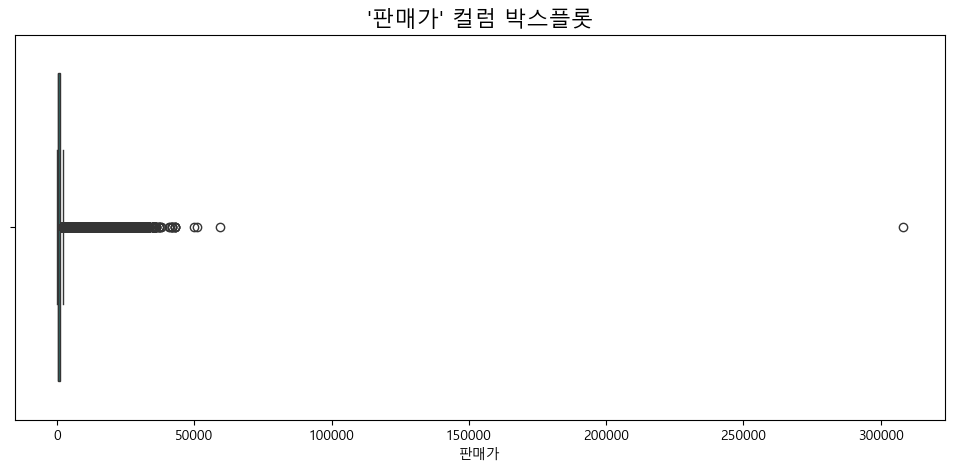


- **'판매량'** 컬럼 이상치 정보:
  - 이상치 수: **306,477개** (10.44%)
  - IQR 기반 정상 범위: `1.00` ~ `1.00`
  - 분위수 기반 범위:
    * 1% ~ 99%: `1.00` ~ `5.00`
    * 5% ~ 95%: `1.00` ~ `2.00`


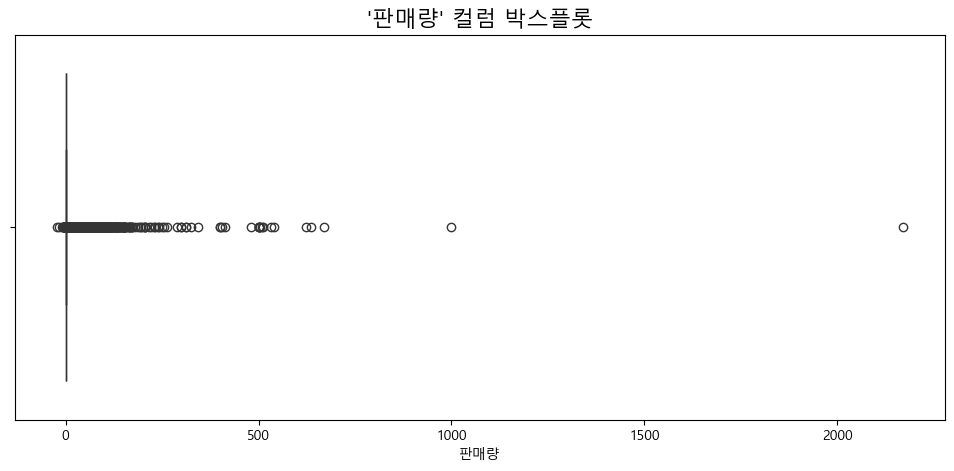


## 7. 범주형 컬럼 분포
---

- **'상점명'** 컬럼 (고유값: **60개**):
| 상점명                          |   개수 |   비율(%) |
|:--------------------------------|-------:|----------:|
| Москва ТЦ "Семеновский"         | 235636 |   8.02616 |
| Москва ТРК "Атриум"             | 186104 |   6.33902 |
| Химки ТЦ "Мега"                 | 143480 |   4.88717 |
| Москва ТЦ "МЕГА Теплый Стан" II | 142234 |   4.84473 |
| Якутск Орджоникидзе, 56         | 117428 |   3.9998  |
| СПб ТК "Невский Центр"          | 109253 |   3.72134 |
| Москва ТЦ "МЕГА Белая Дача II"  | 105366 |   3.58894 |
| Воронеж (Плехановская, 13)      |  82663 |   2.81564 |
| Якутск ТЦ "Центральный"         |  71441 |   2.4334  |
| Чехов ТРЦ "Карнавал"            |  69573 |   2.36977 |
  * 고유값 개수가 50개를 초과하여 시각화를 생략합니다.

- **'상품명'** 컬럼 (고유값: **21807개**):
| 상품명                                                                                |   개수 |   비율(%) |
|:--------------------------------------------------------------------------------------|-------:

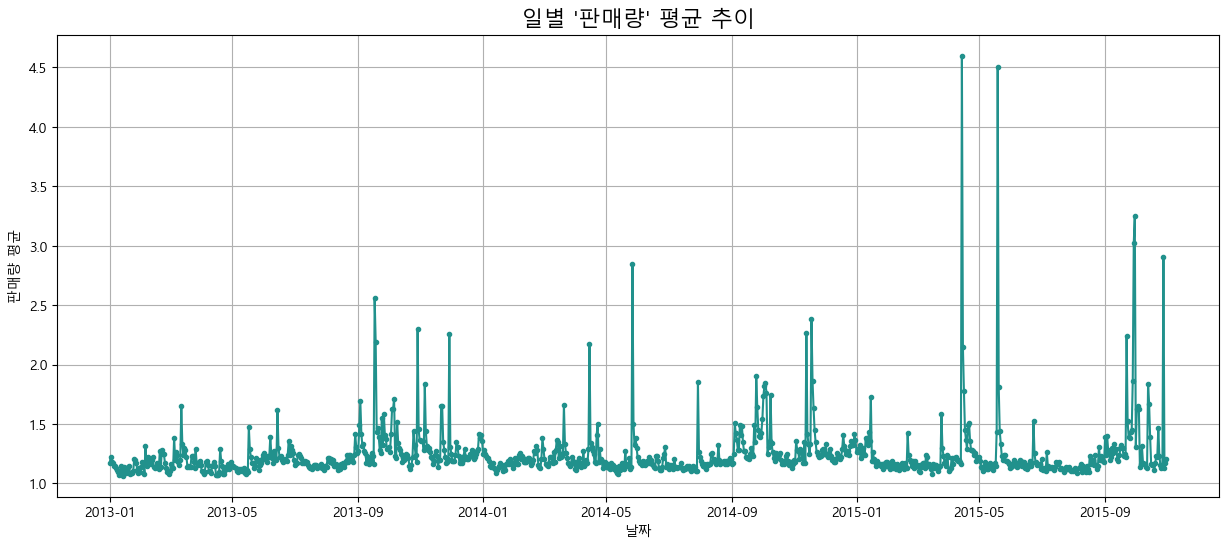

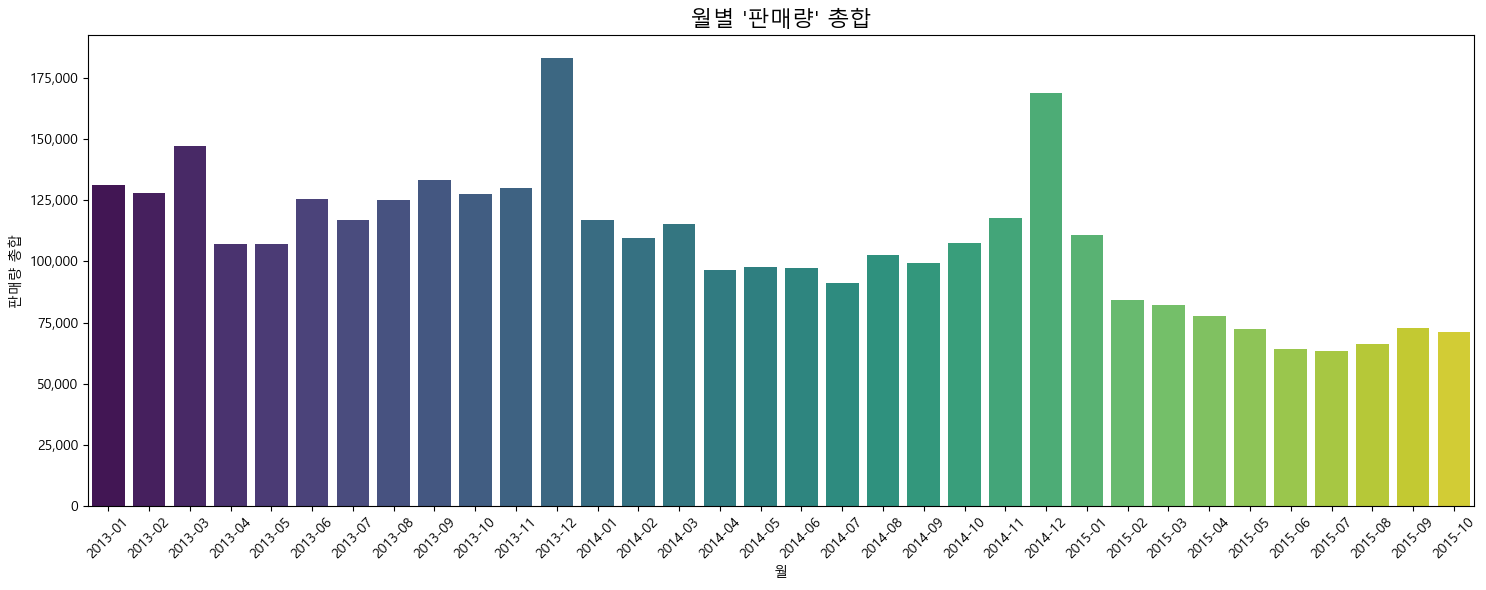


## 9. 수치형 컬럼 간 상관관계
---
**타겟 변수('판매량')와의 상관관계:**
|            |      판매량 |
|:-----------|------------:|
| 상품ID     |  0.0166503  |
| 상품분류ID |  0.0147679  |
| 판매가     |  0.0111966  |
| 월ID       |  0.00940201 |
| 상점ID     | -0.00522969 |


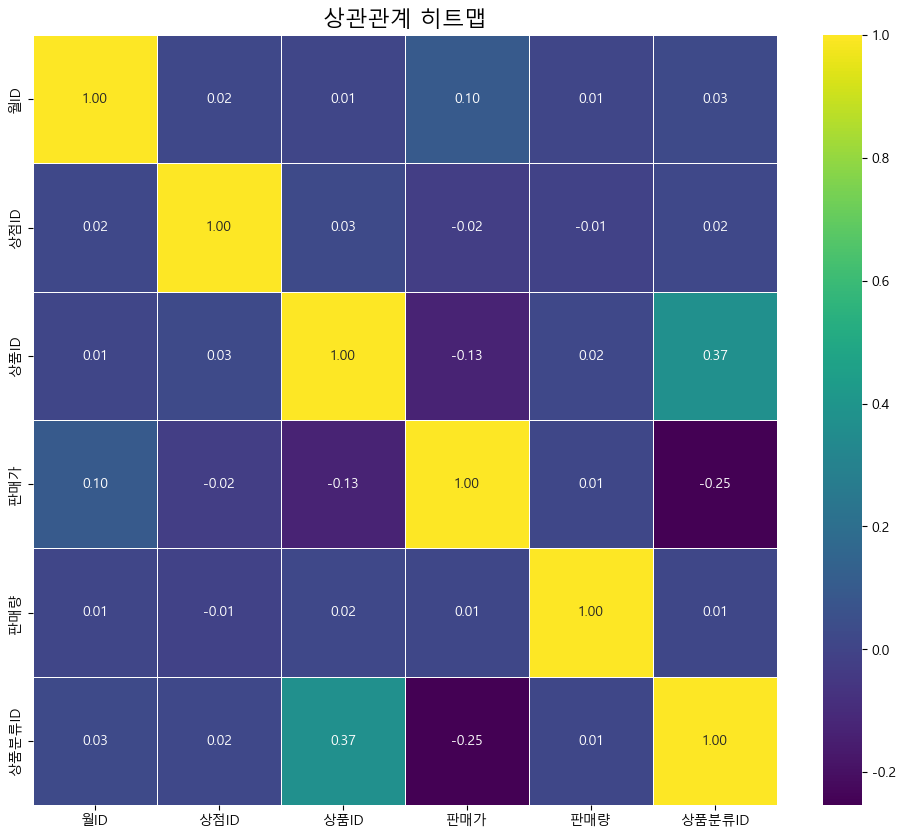


## 10. 그룹별 타겟 변수 분석
---

- 그룹 기준: **'상품분류ID'**, 분석 대상: **'판매량'**

* '상품분류ID'의 고유값이 84개로 많아 총합 기준 **상위 20개**만 시각화합니다.

**[그룹 통계 (X축 기준 정렬)]**
|   상품분류ID |   count |     mean |    sum |         std |
|-------------:|--------:|---------:|-------:|------------:|
|            0 |       3 | 1        |      3 |   0         |
|            1 |       2 | 1        |      2 |   0         |
|            2 |   18461 | 1.06154  |  19597 |   0.348973  |
|            3 |   25283 | 1.17893  |  29807 |   0.675685  |
|            4 |    2304 | 1.0447   |   2407 |   0.390061  |
|            5 |    7231 | 1.02517  |   7413 |   0.226043  |
|            6 |   18498 | 1.10671  |  20472 |   0.444056  |
|            7 |    4459 | 1.20161  |   5358 |   0.900345  |
|            8 |    1877 | 7.29835  |  13699 |  26.6528    |
|            9 |    2193 | 8.26174  |  18118 |  49.9135    |
|           10 |       1 | 1        |      1 | nan         |
|           11 |    6109 | 1.04813  |   6403 |   0.352708  |
|       

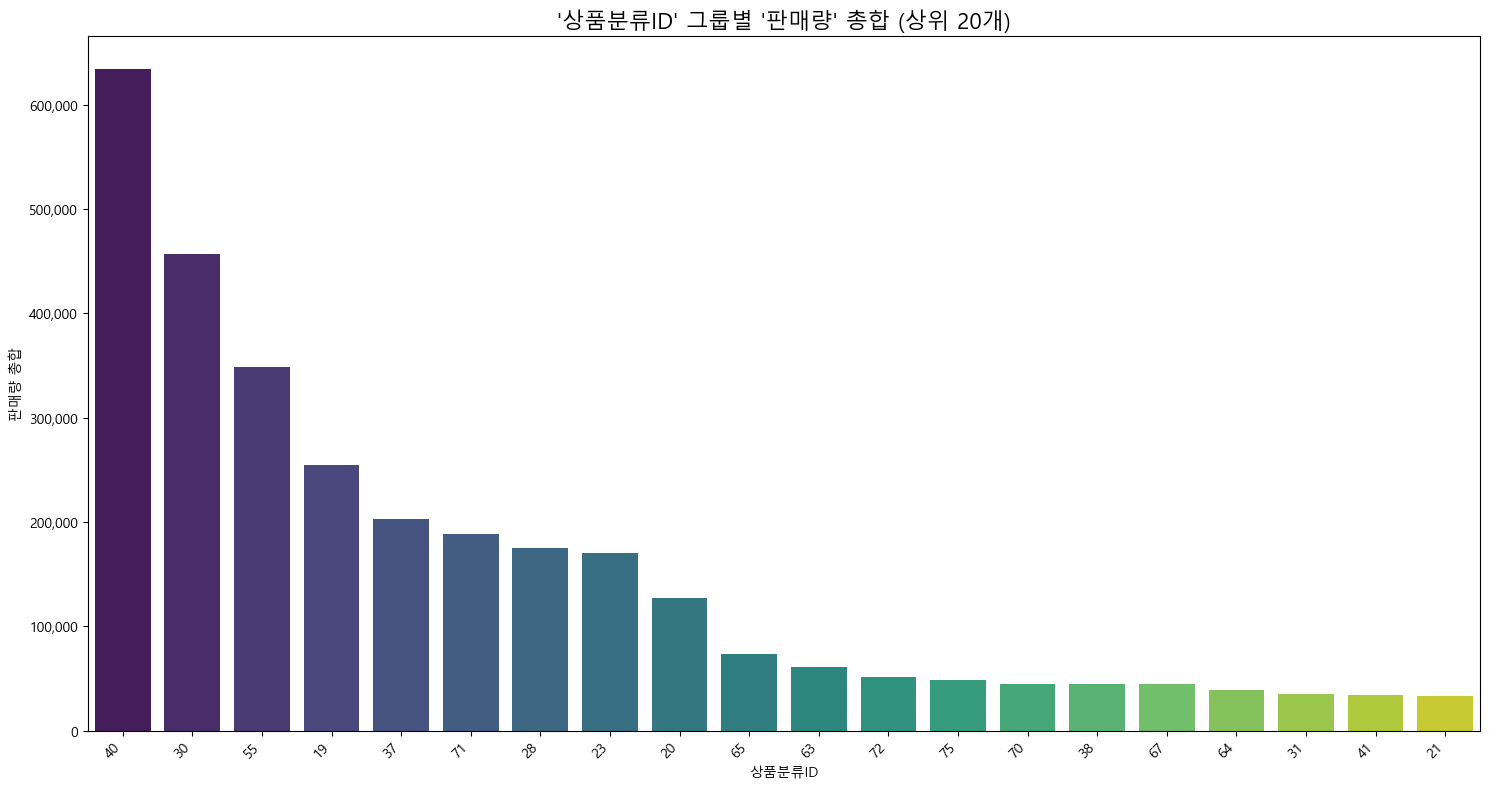


- 그룹 기준: **'상점ID'**, 분석 대상: **'판매량'**

* '상점ID'의 고유값이 60개로 많아 총합 기준 **상위 20개**만 시각화합니다.

**[그룹 통계 (X축 기준 정렬)]**
|   상점ID |   count |    mean |    sum |       std |
|---------:|--------:|--------:|-------:|----------:|
|        0 |    9857 | 1.18748 |  11705 |  0.633668 |
|        1 |    5678 | 1.11148 |   6311 |  0.507896 |
|        2 |   25991 | 1.1781  |  30620 |  1.10973  |
|        3 |   25532 | 1.11057 |  28355 |  0.991501 |
|        4 |   38242 | 1.14905 |  43942 |  1.05942  |
|        5 |   38179 | 1.12004 |  42762 |  0.974112 |
|        6 |   82663 | 1.21565 | 100489 |  1.72236  |
|        7 |   58076 | 1.15466 |  67058 |  1.00549  |
|        8 |    3412 | 1.05363 |   3595 |  0.310656 |
|        9 |    3751 | 4.22981 |  15866 |  7.99193  |
|       10 |   21397 | 1.1461  |  24523 |  0.969754 |
|       11 |     499 | 1.14629 |    572 |  1.02999  |
|       12 |   34694 | 2.11789 |  73478 | 16.5007   |
|       13 |   17824 | 1.10879 |  19763 |  0.615135 |
|       14 |   36979 | 1.

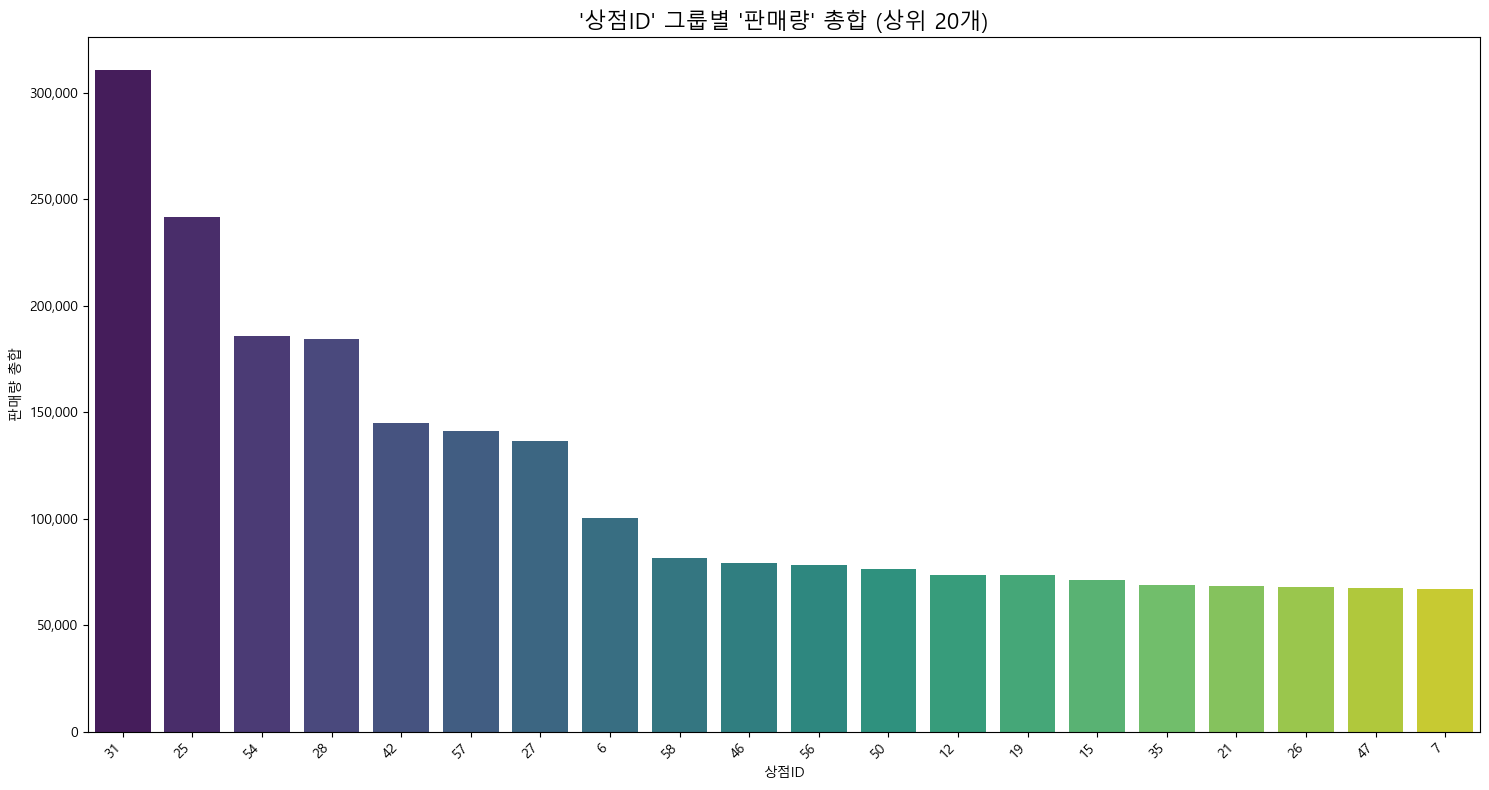


- 그룹 기준: **'월ID'**, 분석 대상: **'판매량'**

* '월ID'의 고유값이 34개로 많아 총합 기준 **상위 20개**만 시각화합니다.

**[그룹 통계 (X축 기준 정렬)]**
|   월ID |   count |    mean |    sum |      std |
|-------:|--------:|--------:|-------:|---------:|
|      0 |  115690 | 1.13648 | 131479 | 0.679514 |
|      1 |  108613 | 1.17932 | 128090 | 0.883316 |
|      2 |  121347 | 1.21257 | 147142 | 1.11283  |
|      3 |   94109 | 1.139   | 107190 | 0.755583 |
|      4 |   91759 | 1.16577 | 106970 | 1.13904  |
|      5 |  100403 | 1.24878 | 125381 | 1.82154  |
|      6 |  100548 | 1.16329 | 116966 | 1.2222   |
|      7 |  104772 | 1.19584 | 125291 | 1.34947  |
|      8 |   96137 | 1.3869  | 133332 | 3.13124  |
|      9 |   94202 | 1.35391 | 127541 | 2.24788  |
|     10 |   96736 | 1.34396 | 130009 | 2.24867  |
|     11 |  143246 | 1.27991 | 183342 | 1.82389  |
|     12 |   99349 | 1.17665 | 116899 | 1.15907  |
|     13 |   89830 | 1.22105 | 109687 | 1.34841  |
|     14 |   92733 | 1.24332 | 115297 | 2.025    |
|     15 |   77906 | 1.

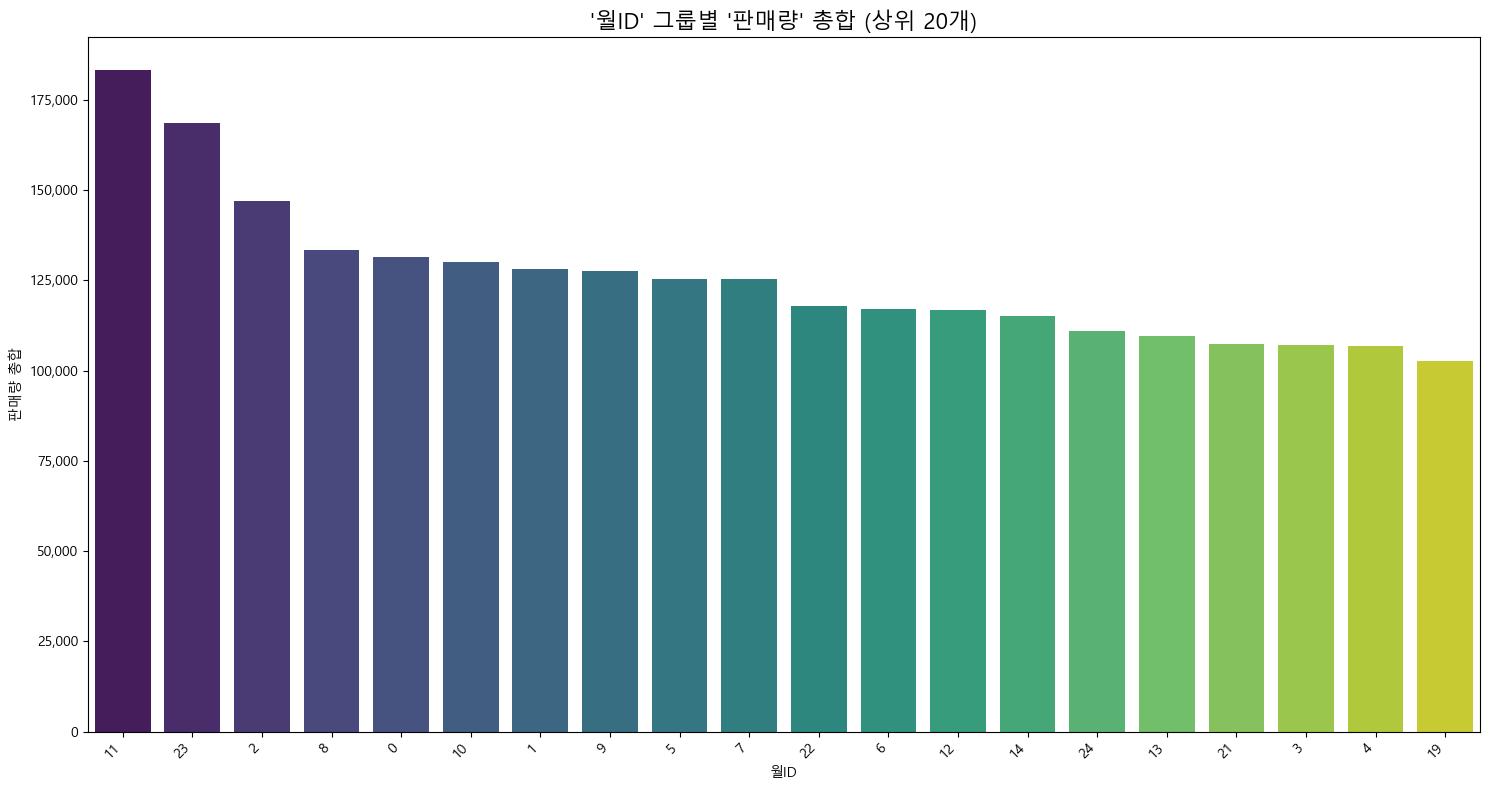


## ✅ EDA 보고서 생성 완료


C:\Users\dodor.HAEWON\AppData\Local\Temp\ipykernel_20148\2090982974.py:18: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all') # 모든 옵션을 기본값으로 리셋
C:\Users\dodor.HAEWON\AppData\Local\Temp\ipykernel_20148\2090982974.py:18: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all') # 모든 옵션을 기본값으로 리셋


In [14]:
# 분석기 생성 및 실행
analyzer = DataFrameAnalyzer(train_data)
analyzer.run_analysis(target_col='판매량', group_cols=["상품분류ID", "상점ID", "월ID"], plot=True)

In [15]:
# 판매량이 음수인 데이터 확인
negative_sales = train_data[train_data['판매량'] < 0]
print(f"음수 판매량 데이터 수: {len(negative_sales):,}개")
print("\n[음수 판매량 데이터]")
print(negative_sales.sort_values('판매량'))

음수 판매량 데이터 수: 7,356개

[음수 판매량 데이터]
                날짜  월ID  상점ID   상품ID          판매가  판매량  \
1057907 2013-11-02   10    12   8023    15.000000  -22   
1835454 2014-07-10   18    14  20949     5.000000  -16   
2048519 2014-10-10   21    12   9242  1433.333333   -9   
59156   2013-01-18    0    12   1590  2599.000000   -6   
940092  2013-10-19    9    42   3732  2599.000000   -6   
...            ...  ...   ...    ...          ...  ...   
1011199 2013-10-05    9     7   3423  1499.000000   -1   
1010442 2013-10-01    9     6  17695   499.000000   -1   
1010066 2013-10-22    9     6  21925   399.000000   -1   
1009439 2013-10-02    9    15   7047   599.000000   -1   
2935779 2015-10-07   33    25   7087   999.000000   -1   

                                상점명  \
1057907         Интернет-магазин ЧС   
1835454     Казань ТЦ "ПаркХаус" II   
2048519         Интернет-магазин ЧС   
59156           Интернет-магазин ЧС   
940092       СПб ТК "Невский Центр"   
...                             ..